<a href="https://colab.research.google.com/github/TEERAWATL/Brain_tumer_MRI_classification_Resnet50_pytourch/blob/main/Brain_tumer_MRI_Lassification_by_Resnet50_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/brain_tumer_MRI_images'

In [3]:
import os
import glob

# Get the list of all image file paths
supported_extensions = ('*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff')  # Add more extensions if needed
image_paths = []
for ext in supported_extensions:
    image_paths.extend(glob.glob(os.path.join(dataset_path, '*/*' + ext)))

print(f"Loaded {len(image_paths)} image paths")

Loaded 4415 image paths


In [4]:
# Extract the class labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Convert labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = [label_to_index[label] for label in labels]
print(f"Number of labes {len(labels)} labels")

Number of labes 4415 labels


In [5]:
import pandas as pd

# Create a dictionary with the keys 'image_path' and 'label'
data = {'image_path': image_paths, 'label': labels}

# Create a dataframe from the dictionary
df = pd.DataFrame(data)

# Get the count of images per label
counts = df['label'].value_counts().reset_index()

# Rename the columns of the dataframe
counts.columns = ['label', 'count']

# Map the integer labels to their corresponding class names
counts['label'] = counts['label'].map({v: k for k, v in label_to_index.items()})

# Print the dataframe
counts

label  count
0   Meningioma (de Baixo Grau, Atípico, Anaplási...    625
1   Glioma (Astrocitoma, Ganglioglioma, Glioblasto...    508
2   Glioma (Astrocitoma, Ganglioglioma, Glioblasto...    430
3   Glioma (Astrocitoma, Ganglioglioma, Glioblasto...    346
4   Meningioma (de Baixo Grau, Atípico, Anaplási...    345
5   Meningioma (de Baixo Grau, Atípico, Anaplási...    329
6                                           NORMAL T2    291
7                                           NORMAL T1    272
8   Neurocitoma (Central - Intraventricular, Extra...    261
9   Schwannoma (Acustico, Vestibular - Trigeminal)...    194
10  Neurocitoma (Central - Intraventricular, Extra...    169
11  Schwannoma (Acustico, Vestibular - Trigeminal) T1    153
12  Outros Tipos de Lesões (Abscessos, Cistos, En...    152
13  Schwannoma (Acustico, Vestibular - Trigeminal) T2    123
14  Neurocitoma (Central - Intraventricular, Extra...    112
15  Outros Tipos de Lesões (Abscessos, Cistos, En...     57
16  Outros Tipos de Lesões (Abscessos, Cistos, En...     48

In [7]:
# Get the class name
index_to_label = {
    0: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1',
    1: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+',
    2: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2',
    3: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1',
    4: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+',
    5: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2',
    6: 'NORMAL T1',
    7: 'NORMAL T2',
    8: 'Neurocitoma (Central - Intraventricular, Extraventricular) T1',
    9: 'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+',
    10: 'Neurocitoma (Central - Intraventricular, Extraventricular) T2',
    11: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1',
    12: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+',
    13: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2',
    14: 'Schwannoma (Acustico, Vestibular - Trigeminal) T1',
    15: 'Schwannoma (Acustico, Vestibular - Trigeminal) T1C+',
    16: 'Schwannoma (Acustico, Vestibular - Trigeminal) T2'
}


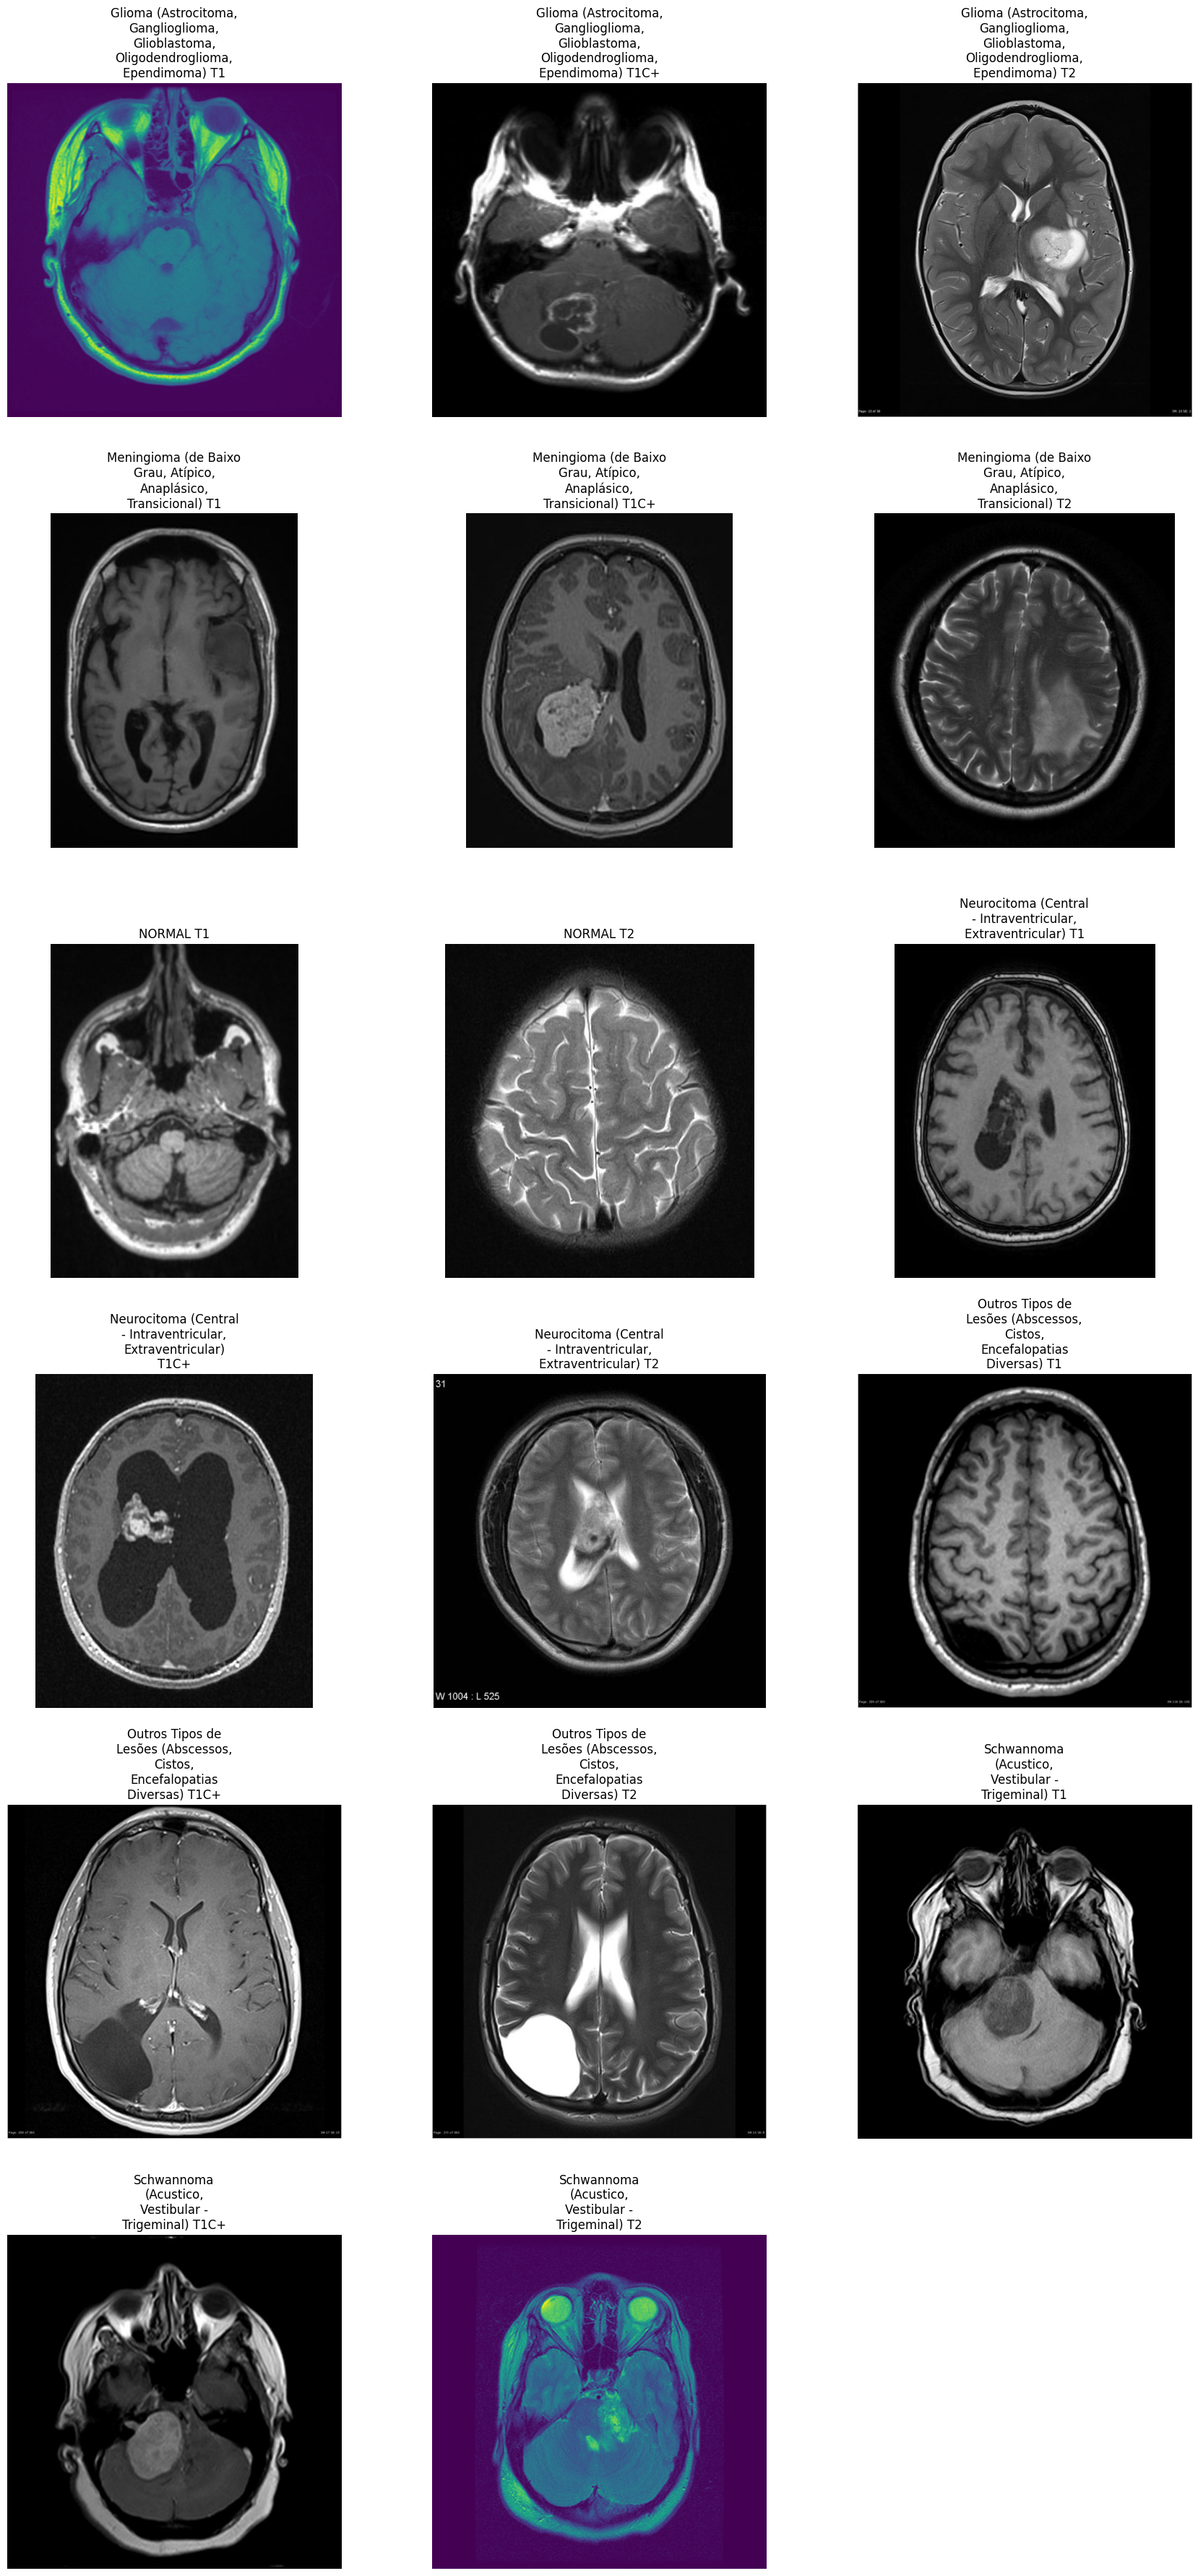

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import textwrap

def wrap_text(text, width=20):
    return '\n'.join(textwrap.wrap(text, width=width))

def show_sample_images(image_paths, labels):
    unique_labels = sorted(set(labels))
    sample_images = []

    for label in unique_labels:
        for i, path in enumerate(image_paths):
            if labels[i] == label:
                sample_images.append(path)
                break

    num_samples = len(sample_images)
    num_columns = 3
    num_rows = (num_samples + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(6 * num_columns, 6 * num_rows))
    axes = axes.flatten()

    for i, (image_path, ax) in enumerate(zip(sample_images, axes)):
        img = Image.open(image_path)
        ax.imshow(img)
        wrapped_label = wrap_text(index_to_label[unique_labels[i]])
        ax.set_title(wrapped_label, fontsize=12)
        ax.axis('off')

    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(pad=2)
    plt.show()

show_sample_images(image_paths, labels)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# Preprocessing
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# Split the dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Create the datasets
train_dataset = BrainTumorDataset(train_paths, train_labels, transform=data_transforms['train'])
val_dataset = BrainTumorDataset(val_paths, val_labels, transform=data_transforms['val'])

# Create the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_sample(loader, num_images=4):
    # Get a batch of training data
    inputs, classes = next(iter(loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[:num_images])

    # Convert classes tensor to numpy and use index_to_label dictionary
    index_to_label = {v: k for k, v in label_to_index.items()}
    class_names = [index_to_label[label.item()] for label in classes[:num_images].cpu()]

    imshow(out, title=class_names)


Training samples:


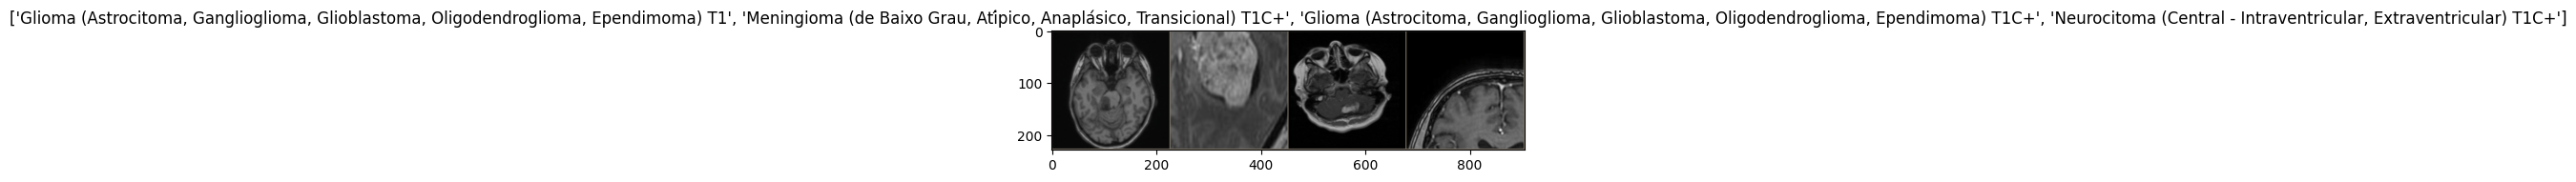

Validation samples:


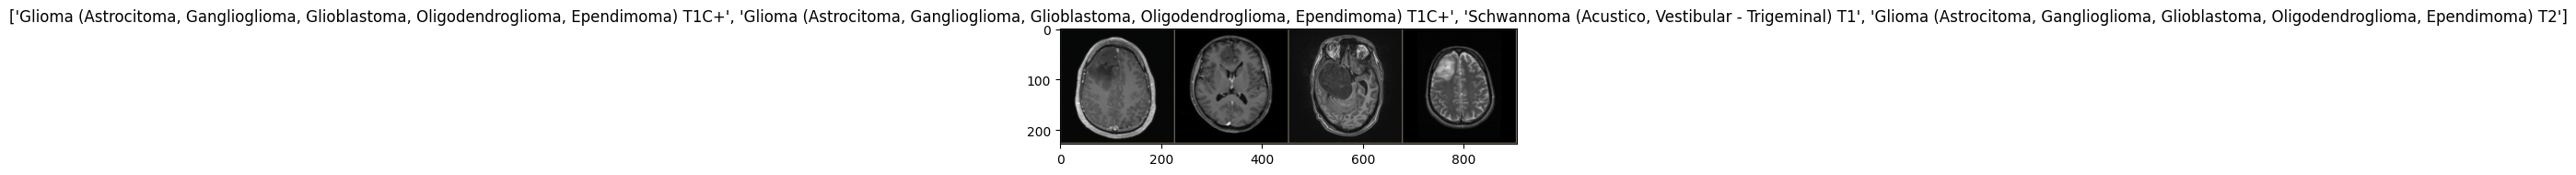

In [ ]:
print("Training samples:")
show_sample(train_loader)

print("Validation samples:")
show_sample(val_loader)


In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)

# Replace the last layer to match the number of classes
num_classes = 17
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 247MB/s]


In [ ]:
import time

start_time = time.time()
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Unfreeze the classifier layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

In [ ]:
epochs = 25

for i in range(epochs):
    print(f"Epoch {i + 1}/{epochs}")
    trn_corr = 0
    tst_corr = 0
    progress_bar = tqdm(train_loader, desc="Training", ncols=800)
    
    for b, (X_train, y_train) in enumerate(progress_bar):
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = resnet50(X_train)
        loss = criterion(y_pred, y_train)

        # True predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item(), accuracy=(trn_corr.item() * 100 / ((b + 1) * X_train.shape[0])))

    loss = loss.detach().cpu().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    progress_bar = tqdm(val_loader, desc="Validation", ncols=800)
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(progress_bar):
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = resnet50(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr

            progress_bar.set_postfix(loss=loss.item(), accuracy=(tst_corr.item() * 100 / ((b + 1) * X_test.shape[0])))

        loss = loss.detach().cpu().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch 1/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 2/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 3/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 4/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 5/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 6/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 7/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 8/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 9/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 10/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 11/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 12/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 13/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 14/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 15/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 16/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 17/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 18/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 19/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 20/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 21/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 22/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 23/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 24/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …

Epoch 25/25


Training:   0%|                                                                                               …

Validation:   0%|                                                                                             …


Duration: 1955 seconds


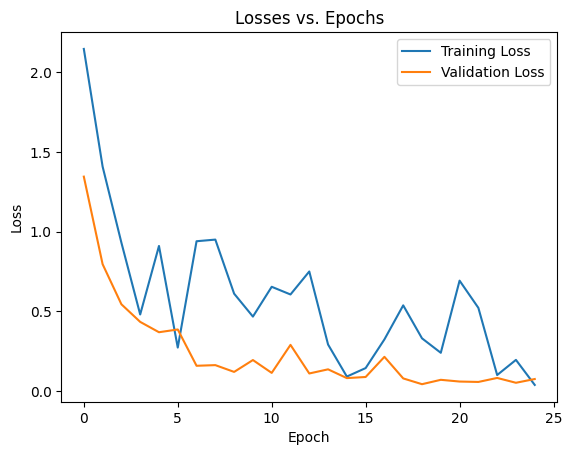

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses vs. Epochs")
plt.show()

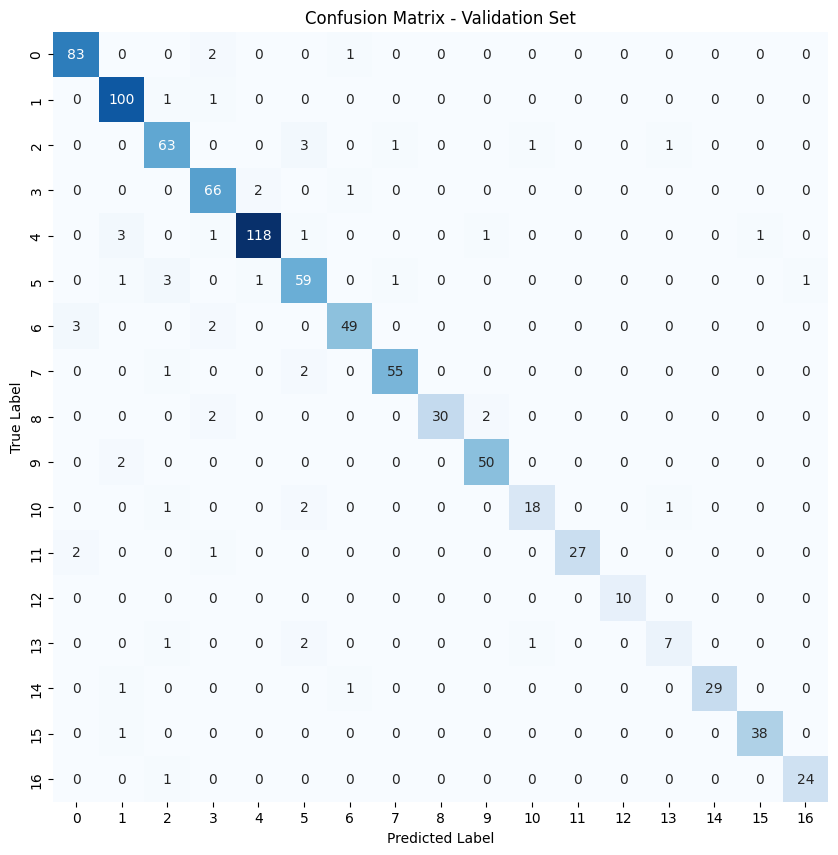

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Round the values to 2 decimal places
report_df = report_df.round(2)

report_df

precision  recall  f1-score  support
0                  0.94    0.97      0.95    86.00
1                  0.93    0.98      0.95   102.00
2                  0.89    0.91      0.90    69.00
3                  0.88    0.96      0.92    69.00
4                  0.98    0.94      0.96   125.00
5                  0.86    0.89      0.87    66.00
6                  0.94    0.91      0.92    54.00
7                  0.96    0.95      0.96    58.00
8                  1.00    0.88      0.94    34.00
9                  0.94    0.96      0.95    52.00
10                 0.90    0.82      0.86    22.00
11                 1.00    0.90      0.95    30.00
12                 1.00    1.00      1.00    10.00
13                 0.78    0.64      0.70    11.00
14                 1.00    0.94      0.97    31.00
15                 0.97    0.97      0.97    39.00
16                 0.96    0.96      0.96    25.00
accuracy           0.94    0.94      0.94     0.94
macro avg          0.94    0.92      0.93   883.00
weighted avg       0.94    0.94      0.94   883.00

1. accuracy: The overall accuracy of the model is 0.94, which means the model correctly predicted 94% of the instances in the dataset.

2. macro avg: The macro averages give equal weight to each class, regardless of its support. In this case, the macro averages for precision, recall, and F1-score are 0.94, 0.92, and 0.93, respectively. The support value (883) represents the total number of instances in the dataset.

3. weighted avg: The weighted averages give more importance to classes with more instances. In this case, the weighted averages for precision, recall, and F1-score are 0.94, 0.94, and 0.94, respectively. The support value (883) represents the total number of instances in the dataset.

In [ ]:
# Define the path to save the model in your Google Drive
save_path = "/content/drive/MyDrive/brain_tumer_MRI_images/resnet50_brain_tumor.pth"

# Save the model's state dictionary
torch.save(resnet50.state_dict(), save_path)


Saving normal (1).jpg to normal (1) (2).jpg


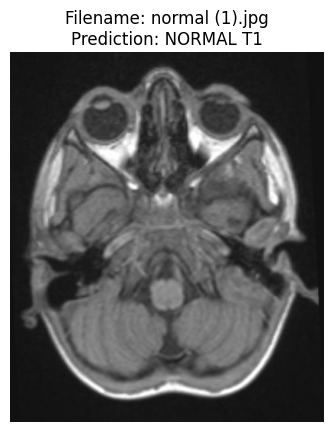

In [ ]:
from google.colab import files
import cv2
from PIL import Image
from io import BytesIO
from torchvision import models
import torchvision.transforms as transforms

# Step 1: Upload images
uploaded = files.upload()

# Step 2: Load the saved model
save_path = "/content/drive/MyDrive/brain_tumer_MRI_images/resnet50_brain_tumor.pth"
state_dict = torch.load(save_path)

loaded_resnet50 = models.resnet50(pretrained=False)
num_ftrs = loaded_resnet50.fc.in_features
loaded_resnet50.fc = nn.Linear(num_ftrs, num_classes)
loaded_resnet50.load_state_dict(state_dict)
loaded_resnet50.eval()

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaded_resnet50.to(device)

# Step 3: Create a function to preprocess the images
def preprocess_image(img):
    img = img.convert('RGB')  # Convert image to RGB format
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor


# Step 4: Make predictions

index_to_label = {v: k for k, v in label_to_index.items()}

for filename, file_contents in uploaded.items():
    img = Image.open(BytesIO(file_contents))
    preprocessed_img = preprocess_image(img).to(device)
    
    with torch.no_grad():
        output = loaded_resnet50(preprocessed_img)
        prediction = torch.argmax(output, dim=1).item()
        class_name = index_to_label[prediction]

    # Display image and prediction
    plt.figure()
    plt.imshow(img)
    plt.title(f"Filename: {filename}\nPrediction: {class_name}")
    plt.axis("off")
    plt.show()

#Part For Using in REST API#

1. Clone the code or download app.py and resnet50_brain_tumor.pth files in to you local.

2. Open a terminal or command prompt and navigate to the directory where the code is located.

3. Create a virtual environment by running the following command:
python -m venv myenv

4. Activate the virtual environment by running the following command on Windows: myenv\Scripts\activate

5. Install the required libraries by running the following command:
pip install torch torchvision Pillow flask

6. python app.py

#FOR Test on Postman#

1. Launch Postman.

2. Create a new request by clicking on the "New" button in the top left corner.

3. Select the "POST" method from the dropdown menu.

4. In the "URL" field, enter the following address: http://localhost:5000/predict. This assumes that you are running the API locally on your machine and the default Flask port is 5000.

5. In the "Body" section, select "form-data" as the data type.

6. In the "Key" field, enter "file".

7. In the "Value" field, click on the "Choose Files" button and select an image file from your computer.

8. Click on the "Send" button to send the request to the API.

9. The API will respond with a JSON object that contains the predicted class name of the brain tumor.

10. You can also check the status code of the response to ensure that the API call was successful. A status code of 200 indicates a successful response.

#Part for use REST API in calab (option)

In [ ]:
!pip install flask flask-restful

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install flask-ngrok


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import io
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import imghdr
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

# The rest of your Flask app code ...



In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2023-05-03 10:00:09--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.28M  3.37MB/s    in 6.9s    

2023-05-03 10:00:17 (1.91 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!./ngrok authtoken 2PHBDZK6LONX4fyTKungRgZA4Mu_69QxMoJUfiFwPmeETP13N

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
get_ipython().system_raw('./ngrok http 5000 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://21ca-35-204-44-35.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040
